In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import os
print('TensorFlow ', tf.__version__)

TensorFlow  2.0.0-beta0


In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
os.environ['TF_XLA_FLAGS'] = '--tf_xla_cpu_global_jit'

In [5]:
batch_size = 256

def get_distances(embeddings):
    """embeddings : shape == [batch_size, EMBEDDING_DIM]
       return distances : shape == [batch_size, batch_size]
    """

    dot = tf.matmul(embeddings, embeddings, transpose_b=True)
    squared_norms = tf.expand_dims(tf.linalg.diag_part(dot), 0)
    squared_norms_t = tf.transpose(squared_norms)
    squared_distances = squared_norms + squared_norms_t - 2 * dot

    zero_mask = tf.equal(squared_distances, 0)
    squared_distances = squared_distances + tf.cast(zero_mask, dtype=tf.float32)*1e-14
    distances = tf.sqrt(squared_distances)
    distances = distances * (1 - tf.cast(zero_mask, dtype=tf.float32))
    return distances

def get_negative_mask(labels):
    """label(a) != label(b)"""
    labels = tf.expand_dims(labels, axis=1)
    labels_t = tf.transpose(labels)
    mask = tf.logical_not(tf.equal(labels, labels_t))
    return mask

def get_positive_mask(labels):
    """label(a) == label(b) && a != b """
    batch_shape = tf.shape(labels)[0]
    mask_1 = tf.logical_not(get_negative_mask(labels))
    mask_2 = tf.logical_not(tf.eye(batch_shape, dtype=tf.bool))
    return tf.logical_and(mask_1, mask_2)

def triplet_loss(labels, embeddings, margin=0.5):
    """embeddings : shape == [batch_size, EMBEDDING_DIM]
       labels : shape == [batch_size]
    """
    distances = get_distances(embeddings)
    positive_mask = get_positive_mask(labels)
    negative_mask = get_negative_mask(labels)

    ## hard positive samples
    positive_distances = tf.cast(positive_mask, dtype=tf.float32) * distances
    hard_positive_distances = tf.expand_dims(tf.reduce_max(positive_distances, axis=1), axis=1)

    ## hard negative samples
    max_distance = tf.expand_dims(tf.reduce_max(distances, axis=1), axis=1)
    hard_negative_distaces = tf.expand_dims(tf.reduce_min(distances + (1 - tf.cast(negative_mask, dtype=tf.float32)) * max_distance, axis=1), axis=1)
    
    ## final loss
    loss = hard_positive_distances - hard_negative_distaces + margin
    loss = tf.maximum(loss, 0)
    return tf.reduce_mean(loss, axis=0)

In [6]:
train_dataset, test_dataset = tfds.load('mnist', split=['train', 'test'])

def preprocess_data(sample):
    image = tf.cast(sample['image'], dtype=tf.float32) / 255.
    label = sample['label']
    return image, label

train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(4096)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(4096)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

print(train_dataset)

<PrefetchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>


In [7]:
def conv_block(tensor, nfilters, kernel_size=3, strides=1):
    y = tf.keras.layers.Conv2D(filters=nfilters, 
                               kernel_size=(3, 3), 
                               padding='valid', 
                               strides=strides, 
                               use_bias=False, 
                               kernel_initializer='he_normal', 
                               kernel_regularizer=tf.keras.regularizers.l2(l=1e-4))(tensor)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.ReLU()(y)
    return y

def model_fn():
    input_layer = tf.keras.layers.Input(shape=(28, 28, 1))
    x = conv_block(input_layer, nfilters=16, kernel_size=3, strides=1)
    x = conv_block(x, nfilters=32, kernel_size=3, strides=1)
    x = conv_block(x, nfilters=64, kernel_size=3, strides=2)
    x = conv_block(x, nfilters=64, kernel_size=3, strides=1)
    x = conv_block(x, nfilters=64, kernel_size=3, strides=1)
    output_layer = tf.keras.layers.GlobalAveragePooling2D()(x)
    return tf.keras.Model(inputs=[input_layer], outputs=[output_layer], name='embedding_model')

In [8]:
model = model_fn()
model.summary()
epochs = 50
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

@tf.function()
def train_fn(images, labels):
    with tf.GradientTape() as Tape:
        embeddings = model(images, training=True)
        loss = triplet_loss(labels, embeddings)
    gradients = Tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function()
def validation_fn(images, labels):
    embeddings = model(images, training=True)
    loss = triplet_loss(labels, embeddings)
    return loss

batch_losses = []
validation_losses = []
for ep in range(epochs):
    epoch_loss = []
    epoch_loss_vaidation = []
    print('Epoch {}/{}'.format(ep+1, epochs))
    for step, batch in enumerate(train_dataset):
        images = batch[0]
        labels = batch[1]
        loss = train_fn(images, labels)
        loss_numpy = loss[0].numpy()
        epoch_loss.append(loss)
#         if step % 25 == 0:
#             print('Loss at epoch {} step {} = {:.4f}'.format(ep+1, step + 1, loss_numpy))        
    mean_loss = np.mean(epoch_loss)
    batch_losses.append(mean_loss)
    print('Loss at end of {} epochs = {:.4f}'.format(ep+1, mean_loss))
    
    for step, batch in enumerate(test_dataset):
        images = batch[0]
        labels = batch[1]
        loss = validation_fn(images, labels)
        loss_numpy = loss[0].numpy()
        epoch_loss_vaidation.append(loss)
    val_mean_loss = np.mean(epoch_loss_vaidation)
    validation_losses.append(val_mean_loss)
    print('Validation loss at end of {} epochs = {:.4f}\n'.format(ep+1, val_mean_loss))

Model: "embedding_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        144       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 16)        64        
_________________________________________________________________
re_lu (ReLU)                 (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 24, 24, 32)    

W0704 17:57:49.968950 139840408057664 deprecation.py:323] From /home/rtx/tensorflow_nightly/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Loss at end of 1 epochs = 0.6952
Validation loss at end of 1 epochs = 0.5978

Epoch 2/50
Loss at end of 2 epochs = 0.5788
Validation loss at end of 2 epochs = 0.5513

Epoch 3/50
Loss at end of 3 epochs = 0.5418
Validation loss at end of 3 epochs = 0.5233

Epoch 4/50
Loss at end of 4 epochs = 0.5179
Validation loss at end of 4 epochs = 0.4985

Epoch 5/50
Loss at end of 5 epochs = 0.4956
Validation loss at end of 5 epochs = 0.4807

Epoch 6/50
Loss at end of 6 epochs = 0.4679
Validation loss at end of 6 epochs = 0.4463

Epoch 7/50
Loss at end of 7 epochs = 0.4220
Validation loss at end of 7 epochs = 0.4054

Epoch 8/50
Loss at end of 8 epochs = 0.3814
Validation loss at end of 8 epochs = 0.3561

Epoch 9/50
Loss at end of 9 epochs = 0.3269
Validation loss at end of 9 epochs = 0.3229

Epoch 10/50
Loss at end of 10 epochs = 0.2836
Validation loss at end of 10 epochs = 0.2883

Epoch 11/50
Loss at end of 11 epochs = 0.2444
Validation loss at end of 11 epochs = 0.2830

Epoch 12/50
Loss at end of

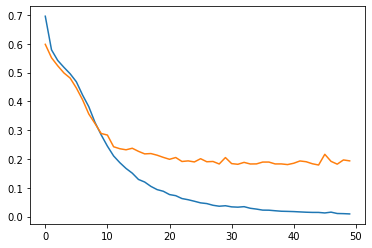

In [9]:
plt.figure()
plt.plot(batch_losses)
plt.plot(validation_losses)

In [10]:
model.save('model.h5')
# model = tf.keras.models.load_model('model.h5')

In [11]:
embeddings = np.zeros(shape=[10000, 64])
images = np.zeros(shape=[10000, 28, 28, 1])
labels = np.zeros(shape=[10000])
test_data = tfds.load('mnist', split=['test'])[0]
for i, sample in tqdm_notebook(enumerate(test_data.take(10000))):
    img = sample['image']
    images[i] = img.numpy()
    embedding = model(tf.cast(img[None, ...], dtype=tf.float32)/255.)[0]
    embeddings[i] = embedding.numpy()
    labels[i] = np.uint8(sample['label'].numpy())
embeddings = tf.constant(embeddings, dtype=tf.float32)
labels = tf.constant(labels, dtype=tf.float32)

In [12]:
class Index:
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.dot_embeddings = tf.matmul(embeddings, embeddings, transpose_b=True)
        self.squared_norms_embeddings = tf.expand_dims(tf.linalg.diag_part(self.dot_embeddings), 0)
        self.labels = labels
        
    def get_labels(self, query_vector, top_k=None):
        dot_query_vector = tf.matmul(query_vector, query_vector, transpose_b=True)
        squared_norms_query_vector = tf.expand_dims(tf.linalg.diag_part(dot_query_vector), 0)
        dot_product = tf.reduce_sum(self.embeddings * query_vector, axis=1)
        distances = tf.maximum(self.squared_norms_embeddings + squared_norms_query_vector - 2 * dot_product, 0)
        sorted_indices =  tf.argsort(distances)
        if top_k:
            sorted_indices = sorted_indices[..., :top_k]
        nearest_labels =  tf.reshape(tf.gather(self.labels, sorted_indices), shape=[-1, 1])
        nearest_distances = tf.reshape(tf.gather(distances[0], sorted_indices), shape=[-1, 1])
        return nearest_distances[..., 0], nearest_labels[..., 0], sorted_indices[0]

In [13]:
i = 569
query_v = embeddings[i][None,...]
query_img = images[i]
query_label = labels[i]

index = Index(embeddings, labels)
distances_, labels_, indices_ = index.get_labels(query_v, top_k=10)

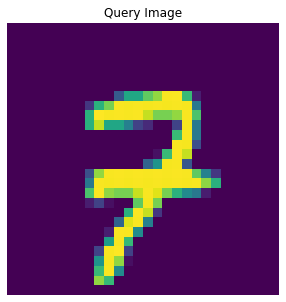

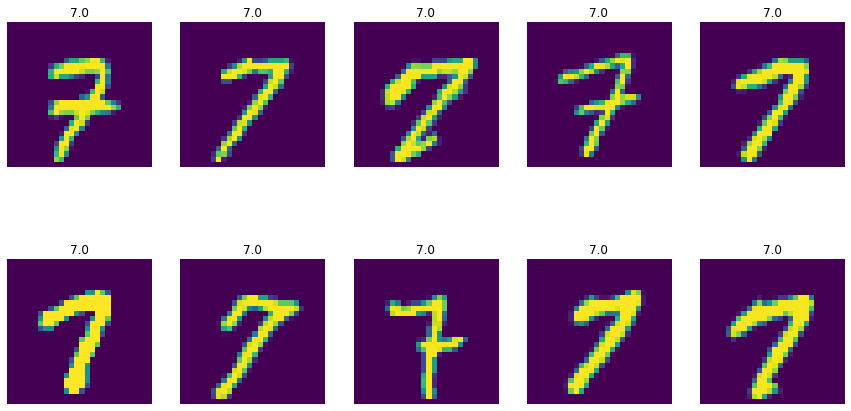

In [14]:
plt.figure(figsize=(5, 5))
plt.title('Query Image')
plt.axis('off')
plt.imshow(query_img[..., 0])
plt.subplots(2, 5, figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.title(labels_[i].numpy())
    plt.axis('off')
    plt.imshow(images[indices_[i]][..., 0])